In [11]:
from pyspark.sql import SparkSession
# import pyarrow

# Create a Spark session
spark = SparkSession.builder.appName("kaggle_eegs").getOrCreate()
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "True")
spark.conf.set("spark.databricks.driver.maxResultSize", "2048m")


In [12]:
file_path = '/home/harraz/my_tensorflow/venv/eegs/training_data/train.csv'

# Read labels CSV file into a DataFrame
train_y = spark.read.csv(file_path, header=True, inferSchema=True)

# Show the DataFrame
train_y.show(10)


+----------+----------+------------------------+--------------+------------------+--------------------------------+----------+----------+----------------+------------+--------+--------+---------+---------+----------+
|    eeg_id|eeg_sub_id|eeg_label_offset_seconds|spectrogram_id|spectrogram_sub_id|spectrogram_label_offset_seconds|  label_id|patient_id|expert_consensus|seizure_vote|lpd_vote|gpd_vote|lrda_vote|grda_vote|other_vote|
+----------+----------+------------------------+--------------+------------------+--------------------------------+----------+----------+----------------+------------+--------+--------+---------+---------+----------+
|1628180742|         0|                     0.0|        353733|                 0|                             0.0| 127492639|     42516|         Seizure|           3|       0|       0|        0|        0|         0|
|1628180742|         1|                     6.0|        353733|                 1|                             6.0|3887563113|     4

In [13]:
from pyspark.sql import DataFrame
from pyspark.storagelevel import StorageLevel


file_path = '/home/harraz/my_tensorflow/venv/eegs/training_data/*.parquet'

# Read parquet file into a DataFrame
train_X = spark.read.parquet(file_path, inferSchema=True).persist(StorageLevel.MEMORY_AND_DISK_DESER)


24/02/04 11:14:57 WARN CacheManager: Asked to cache already cached data.        


In [14]:
# train_X.show(5)

In [15]:
from pyspark.sql.functions import when

train_Labels = train_y.withColumn('expert_consensus', when(train_y['expert_consensus'] == 'Seizure', 1).otherwise(0))
train_Labels = train_Labels.select(train_Labels.expert_consensus) #.limit(100000)
# train_Labels.show(5)

In [16]:
# from pyspark.ml.feature import VectorAssembler, StandardScaler
# from pyspark.ml.linalg import VectorUDT
# from pyspark.sql.functions import col
# # from pyspark.sql.types import DoubleType

# # List of feature columns
# feature_columns = ['Fp1', 'F3', 'C3', 'P3', 'F7', 'T3', 'T5', 'O1', 'Fz', 'Cz', 'Pz', 'Fp2', 'F4', 'C4', 'P4', 'F8', 'T4', 'T6', 'O2', 'EKG']

# # Create a VectorAssembler
# # assembler = VectorAssembler(inputCols=feature_columns, outputCol="features_assembled")
# assembler = VectorAssembler(inputCols=feature_columns, outputCol="features_assembled", handleInvalid="skip")

# # Apply VectorAssembler to the training data
# train_X_assembled = assembler.transform(train_X)

# # Cast the features_assembled column to VectorUDT
# train_X_assembled = train_X_assembled.withColumn("features_assembled", col("features_assembled").cast(VectorUDT()))

# # Create a StandardScaler
# scaler = StandardScaler(inputCol="features_assembled", outputCol="normalized_features", withStd=True, withMean=True)

# # Fit the StandardScaler on the training data
# scaler_model = scaler.fit(train_X_assembled)

# # Transform the training data
# train_X_scaled = scaler_model.transform(train_X_assembled)

# # Display the scaled features
# train_X_scaled.select("normalized_features").show(truncate=False)


In [17]:
# Write the DataFrame to a Parquet file
# train_X_scaled.write.parquet("/home/harraz/my_tensorflow/venv/eegs/training_data/train_X_scaled.parquet")


In [18]:
train_X_scaled = spark.read.parquet("/home/harraz/my_tensorflow/venv/eegs/training_data/train_X_scaled.parquet")
train_X_scaled = train_X_scaled.select('normalized_features') #.limit(100000)
train_X_scaled.printSchema()

root
 |-- normalized_features: vector (nullable = true)



In [19]:
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, FloatType, DoubleType
from pyspark.ml.linalg import VectorUDT

# Assuming "normalized_features" is a VectorUDT
vector_to_array_udf = udf(lambda v: v.toArray().tolist(), ArrayType(FloatType()))

# Apply the UDF to convert "normalized_features" to an array
train_X_scaled = train_X_scaled.withColumn("normalized_features_array", vector_to_array_udf("normalized_features"))

train_X_scaled =train_X_scaled.drop('normalized_features')
# Now, you can use the array as needed, and potentially convert it to a NumPy array
train_X_scaled.show(3)


+-------------------------+
|normalized_features_array|
+-------------------------+
|     [0.32061088, 0.25...|
|     [0.28890824, 0.22...|
|     [0.24639647, 0.18...|
+-------------------------+
only showing top 3 rows



In [20]:
# import numpy as np

# train_X_scaled_np = np.array(train_X_scaled.collect())
# train_Labels_np = np.array(train_Labels.collect())

import numpy as np

# Convert PySpark DataFrames to Pandas DataFrames
train_X_scaled_pd = train_X_scaled.toPandas()
train_Labels_pd = train_Labels.toPandas()

# Convert Pandas DataFrames to NumPy arrays
train_X_scaled_np = train_X_scaled_pd.values
train_Labels_np = train_Labels_pd.values


24/02/04 11:23:23 ERROR TaskSetManager: Total size of serialized results of 29 tasks (1040.9 MiB) is bigger than spark.driver.maxResultSize (1024.0 MiB)
24/02/04 11:23:23 WARN TaskSetManager: Lost task 28.0 in stage 15.0 (TID 20073) (192.168.1.156 executor driver): TaskKilled (Tasks result size has exceeded maxResultSize)
24/02/04 11:23:23 WARN TaskSetManager: Lost task 29.0 in stage 15.0 (TID 20074) (192.168.1.156 executor driver): TaskKilled (Stage cancelled: Job aborted due to stage failure: Total size of serialized results of 29 tasks (1040.9 MiB) is bigger than spark.driver.maxResultSize (1024.0 MiB))
24/02/04 11:23:23 WARN TaskSetManager: Lost task 30.0 in stage 15.0 (TID 20075) (192.168.1.156 executor driver): TaskKilled (Stage cancelled: Job aborted due to stage failure: Total size of serialized results of 29 tasks (1040.9 MiB) is bigger than spark.driver.maxResultSize (1024.0 MiB))
/home/harraz/my_tensorflow/venv/lib/python3.11/site-packages/pyspark/sql/pandas/conversion.py:19

Py4JJavaError: An error occurred while calling o140.getResult.
: org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.security.SocketAuthServer.getResult(SocketAuthServer.scala:98)
	at org.apache.spark.security.SocketAuthServer.getResult(SocketAuthServer.scala:94)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:77)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:568)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:840)
Caused by: org.apache.spark.SparkException: Job aborted due to stage failure: Total size of serialized results of 29 tasks (1040.9 MiB) is bigger than spark.driver.maxResultSize (1024.0 MiB)
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2844)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2780)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2779)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2779)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1242)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1242)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1242)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3048)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2982)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2971)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:984)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2398)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2493)
	at org.apache.spark.sql.Dataset.$anonfun$collectAsArrowToPython$5(Dataset.scala:4274)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.sql.Dataset.$anonfun$collectAsArrowToPython$2(Dataset.scala:4278)
	at org.apache.spark.sql.Dataset.$anonfun$collectAsArrowToPython$2$adapted(Dataset.scala:4254)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$2(Dataset.scala:4334)
	at org.apache.spark.sql.execution.QueryExecution$.withInternalError(QueryExecution.scala:546)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$1(Dataset.scala:4332)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$6(SQLExecution.scala:125)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:201)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:108)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:900)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:66)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:4332)
	at org.apache.spark.sql.Dataset.$anonfun$collectAsArrowToPython$1(Dataset.scala:4254)
	at org.apache.spark.sql.Dataset.$anonfun$collectAsArrowToPython$1$adapted(Dataset.scala:4253)
	at org.apache.spark.security.SocketAuthServer$.$anonfun$serveToStream$2(SocketAuthServer.scala:140)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.security.SocketAuthServer$.$anonfun$serveToStream$1(SocketAuthServer.scala:142)
	at org.apache.spark.security.SocketAuthServer$.$anonfun$serveToStream$1$adapted(SocketAuthServer.scala:137)
	at org.apache.spark.security.SocketFuncServer.handleConnection(SocketAuthServer.scala:114)
	at org.apache.spark.security.SocketFuncServer.handleConnection(SocketAuthServer.scala:108)
	at org.apache.spark.security.SocketAuthServer$$anon$1.$anonfun$run$4(SocketAuthServer.scala:69)
	at scala.util.Try$.apply(Try.scala:213)
	at org.apache.spark.security.SocketAuthServer$$anon$1.run(SocketAuthServer.scala:69)


In [ ]:
print(train_X_scaled_np.shape)
print(train_Labels_np.shape)

(100000, 1, 20)
(100000, 1)


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)
# build keras model with optimizer and 3 layer NN
def build_model():
  model = keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(1, 20)),  # Adjust the input shape
    # tf.keras.layers.GlobalAveragePooling1D(input_shape=(1, 20)),  # Replace Flatten with GlobalAveragePooling1D
    layers.Dense(300, activation=tf.nn.relu),
    layers.Dense(200, activation=tf.nn.relu),
    layers.Dense(100, activation=tf.nn.relu),
    layers.Dense(1, activation=tf.nn.sigmoid)
  ])

  # optimizer = tf.keras.optimizers.RMSprop(0.05)

  # model.compile(loss='mse',
  #               optimizer=optimizer,
  #               metrics=['mse','mae'])
  
  model.compile(loss='binary_crossentropy', 
                optimizer='adam', 
                metrics=['accuracy'], )

  # model.compile(loss=keras.losses.mean_absolute_error,
  #               optimizer=keras.optimizers.SGD(0.4),
  #               metrics=['accuracy'])

  return model

model=build_model()
model.summary()
# keras.utils.plot_model(model, "hd_model.png", show_shapes=True)

EPOCHS = 400
early_stop = keras.callbacks.EarlyStopping(monitor='accuracy', patience=10)
history = model.fit(
    x=train_X_scaled_np, y=train_Labels_np, batch_size=100, epochs=EPOCHS, verbose=1,
    callbacks=[early_stop], validation_split=0.2, validation_data=None, shuffle=True,
    class_weight=None, sample_weight=None, initial_epoch=0, steps_per_epoch=None,
    validation_steps=None, validation_batch_size=None, validation_freq=1,
    max_queue_size=10, workers=2, use_multiprocessing=True
)


2.15.0
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 20)                0         
                                                                 
 dense_12 (Dense)            (None, 300)               6300      
                                                                 
 dense_13 (Dense)            (None, 200)               60200     
                                                                 
 dense_14 (Dense)            (None, 100)               20100     
                                                                 
 dense_15 (Dense)            (None, 1)                 101       
                                                                 
Total params: 86701 (338.68 KB)
Trainable params: 86701 (338.68 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Epoch 1/400
800/800 [==============================] - 23s 24ms/step - loss: 0.4987 - accuracy: 0.8028 - val_loss: 0.4655 - val_accuracy: 0.8256
Epoch 2/400
800/800 [==============================] - 18s 22ms/step - loss: 0.4930 - accuracy: 0.8034 - val_loss: 0.4716 - val_accuracy: 0.8256
Epoch 3/400
800/800 [==============================] - 12s 15ms/step - loss: 0.4895 - accuracy: 0.8034 - val_loss: 0.4692 - val_accuracy: 0.8256
Epoch 4/400
800/800 [==============================] - 7s 9ms/step - loss: 0.4847 - accuracy: 0.8034 - val_loss: 0.4706 - val_accuracy: 0.8256
Epoch 5/400
800/800 [==============================] - 6s 8ms/step - loss: 0.4774 - accuracy: 0.8036 - val_loss: 0.4898 - val_accuracy: 0.8230
Epoch 6/400
800/800 [==============================] - 6s 7ms/step - loss: 0.4681 - accuracy: 0.8048 - val_loss: 0.4905 - val_accuracy: 0.8244
Epoch 7/400
800/800 [==============================] - 6s 8ms/step - loss: 0.4539 - accuracy: 0.8090 - val_loss: 0.5034 - val_accuracy: 

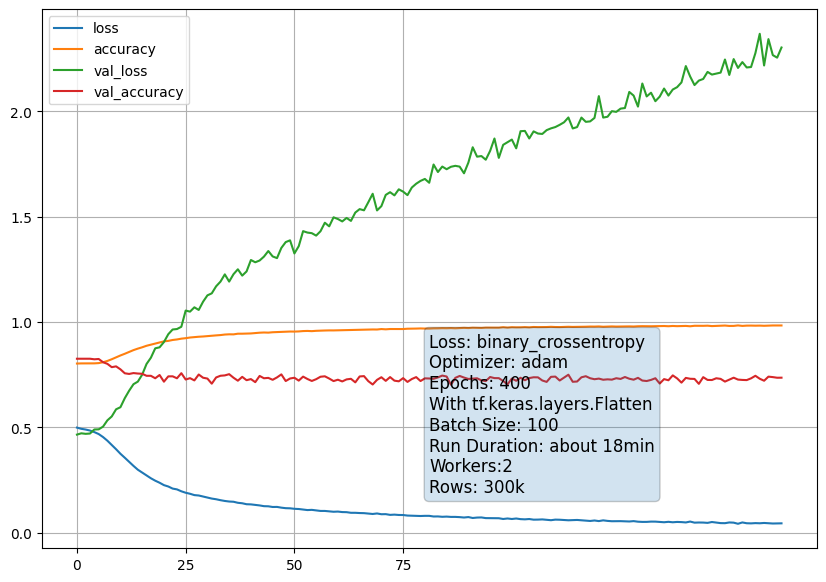

In [ ]:
# To plot pretty figures
import pandas as pd
# import matplotlib as mpl
import matplotlib.pyplot as plt

pd.DataFrame(history.history).plot(figsize=(10, 7))
plt.grid(True)

# Add model parameters as text to the plot
model_params_text = (
    f"Loss: {'binary_crossentropy'}\n"
    f"Optimizer: {'adam'}\nEpochs: 400\n"
        f"With tf.keras.layers.Flatten\nBatch Size: 100\nRun Duration: about 18min\nWorkers:2\nRows: 300k" 
)

plt.text(0.5, 0.4, model_params_text, transform=plt.gca().transAxes,
         fontsize=12, verticalalignment='top', bbox=dict(boxstyle='round', alpha=0.2))

# plt.gca().set_ylim(0, 1)
plt.xticks(np.arange(0, 100, 25))
plt.show()

In [ ]:
# from pyspark.sql.types import StructType, StructField, DoubleType

# # Define the schema struct with DoubleType
# schema_struct_double = StructType([
#     StructField("Fp1", DoubleType(), True),
#     StructField("F3", DoubleType(), True),
#     StructField("C3", DoubleType(), True),
#     StructField("P3", DoubleType(), True),
#     StructField("F7", DoubleType(), True),
#     StructField("T3", DoubleType(), True),
#     StructField("T5", DoubleType(), True),
#     StructField("O1", DoubleType(), True),
#     StructField("Fz", DoubleType(), True),
#     StructField("Cz", DoubleType(), True),
#     StructField("Pz", DoubleType(), True),
#     StructField("Fp2", DoubleType(), True),
#     StructField("F4", DoubleType(), True),
#     StructField("C4", DoubleType(), True),
#     StructField("P4", DoubleType(), True),
#     StructField("F8", DoubleType(), True),
#     StructField("T4", DoubleType(), True),
#     StructField("T6", DoubleType(), True),
#     StructField("O2", DoubleType(), True),
#     StructField("EKG", DoubleType(), True)
# ])
# # Use the VectorAssembler with explicit input and output columns
# assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
# train_X = assembler.transform(train_X)


In [ ]:
import tensorflow as tf

# Initialize a GlobalAveragePooling1D (GAP1D) layer
gap1d_layer = tf.keras.layers.GlobalAveragePooling1D()

# Define sample array
sample_array = np.array([[[10,2],[1,3],[1,1]]])

# Print shape and contents of sample array
print(f'shape of sample_array = {sample_array.shape}')
print(f'sample array: {sample_array}')

# Pass the sample array to the GAP1D layer
output = gap1d_layer(sample_array)

# Print shape and contents of the GAP1D output array
print(f'output shape of gap1d_layer: {output.shape}')
print(f'output array of gap1d_layer: {output.numpy()}')

shape of sample_array = (1, 3, 2)
sample array: [[[10  2]
  [ 1  3]
  [ 1  1]]]
output shape of gap1d_layer: (1, 2)
output array of gap1d_layer: [[4 2]]
